# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Load the dataset
df = pd.read_csv('../dataset/strokeDataSet.csv')

# Data Cleaning

In [2]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### age:
    Mean age is 43.2 years, suggesting the dataset includes both younger and older adults. \
    Std Dev of 22.6 is large → age is widely spread. \
    Min value is 0.08: possibly an infant. \
    Max is 82: includes elderly individuals, a known stroke risk group.


### avg_glucose_level:
    Mean glucose is 106.15 mg/dL. \
    Std Dev is 45.28: indicates significant variation. \
    Max of 271.74 is very high: suggests presence of diabetic/hyperglycemic individuals. \

High glucose levels are risk factors for stroke, this feature may be important in modeling.

### bmi (Body Mass Index)
    Mean is 28.89: close to the overweight range (25–29.9). \
    Max is 97.6: likely indicates extreme obesity. \
    Std Dev is 7.85: some individuals may be underweight or obese.

BMI is a known cardiovascular risk factor, useful for stroke prediction.

### stroke (target variable)
    Mean of 0.049 = 4.9% of patients had a stroke.
    Values are only 0 or 1: this is a binary classification task.
    Highly imbalanced: 95% non-stroke, 5% stroke.

Class imbalance is a challenge, models will need techniques like SMOTE or class weighting.

In [5]:
df.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df.duplicated().sum()
df.fillna({'bmi': df['bmi'].median()}, inplace=True)

### Data Overview & Cleaning
This dataset contains a total of 5,110 rows with no duplicate, and the 'bmi' parameter has 201 missing values. These missing values were filled using the median, based on the assumption that the individuals with missing 'bmi' entries have typical or average bmi values.

### Columns:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

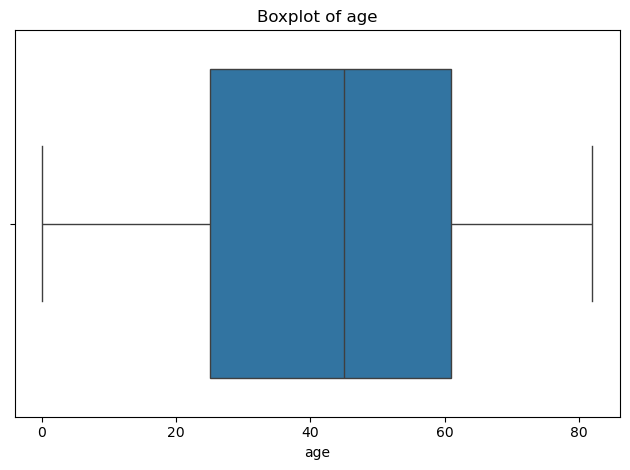

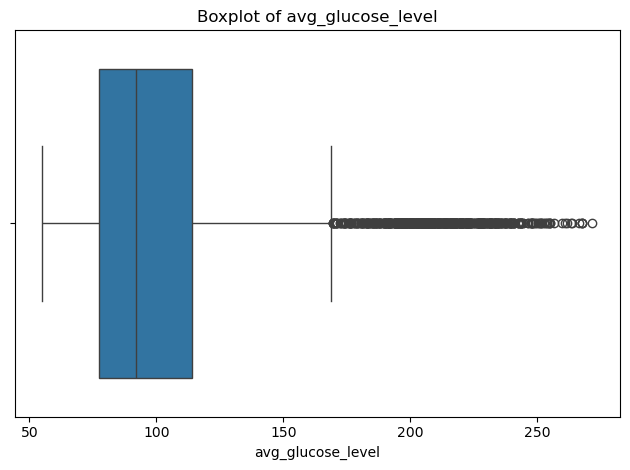

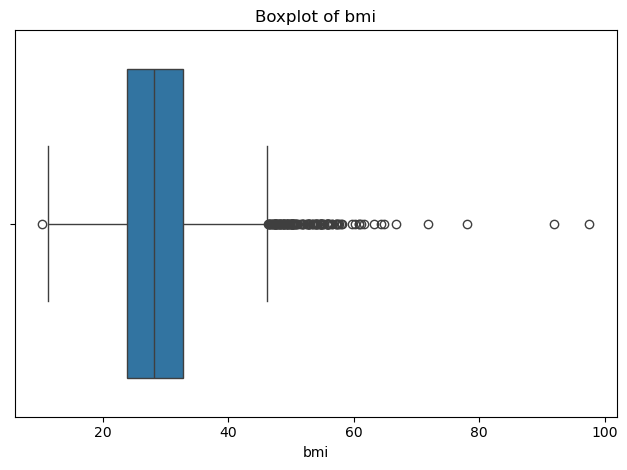

In [7]:
numerical_features = ['age', 'avg_glucose_level', 'bmi']

for col in numerical_features:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.savefig(f'boxplot_{col}.png')
    plt.tight_layout()
    plt.show()


### Interpret boxplots

Boxplots show outliers in bmi and glucose level, but this is reflect the real patient conditions. A stroke patient may actually have a BMI of 90 or glucose of 270, so removing these would hide critical clinical cases!

They are rare but valid, outliers in this dataset can help catch severe cases that models should learn.

# Ultilities

In [18]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    df[col] = df[col].astype('category')


# encoding
df_encoded = pd.get_dummies(df.drop(columns=['id']), drop_first=True)

# Split features and labels
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']


In [19]:
# Display first 5 rows of the encoded data 
df_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,28.1,1,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,False,True,False


# EDA

## Univariate Distribution

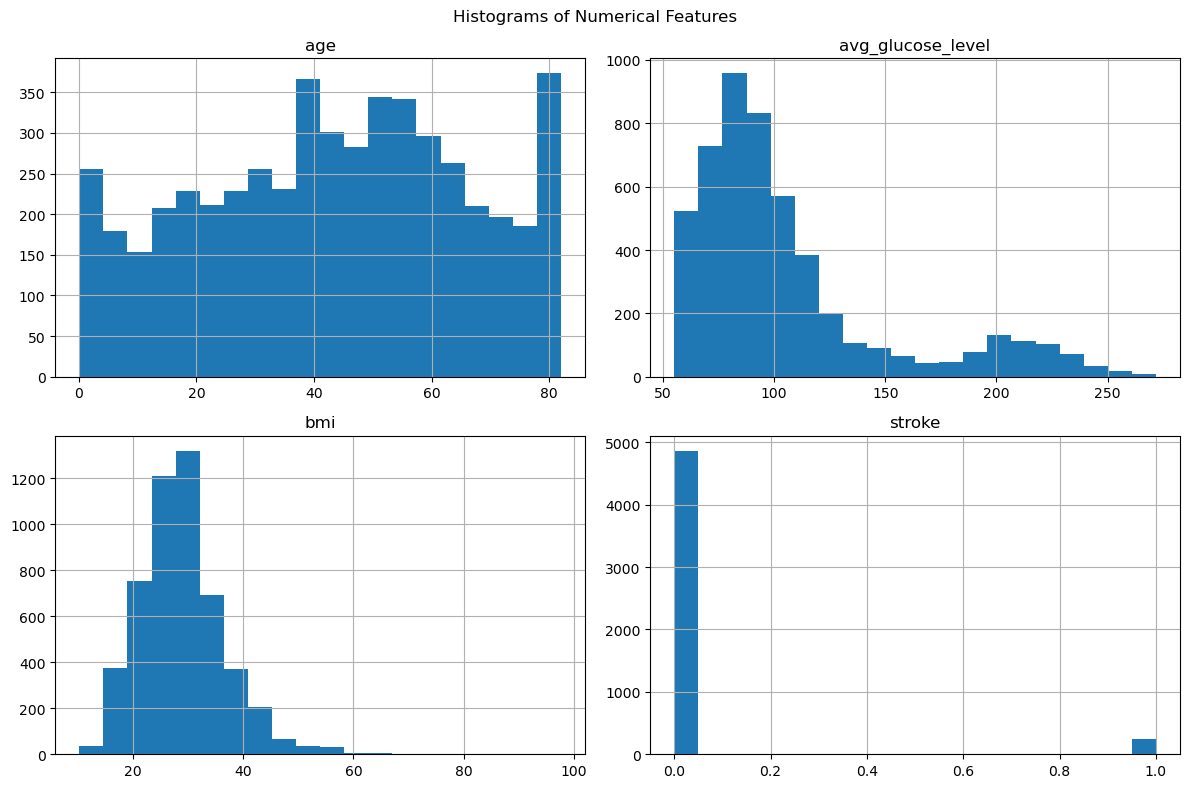

In [10]:
num_cols = ['age', 'avg_glucose_level', 'bmi', 'stroke']
df[num_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.savefig('histograms_numerical_features.png')
plt.tight_layout()
plt.show()

Numerical histograms: "age, avg_glucose_level, bmi" show right-skewed distributions, especially "avg_glucose_level".

Stroke distribution shows heavy imbalance between class 1 (stroke) and class 0 (no stroke) in the dataset. Class 1 is much less than Class 0. This could lead to poor model evaluation. To address this issue, we will use stratified sampling, SMOTE, and class weighting to improve the prediction of class 1 (stroke).  

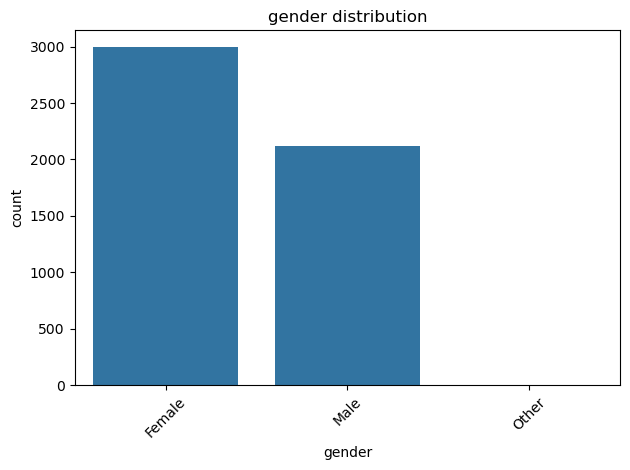

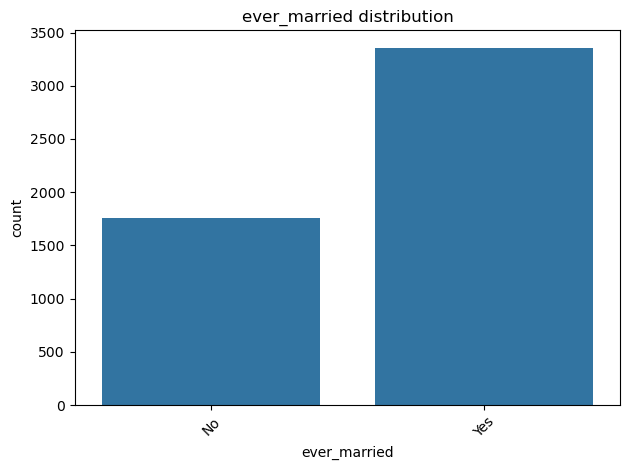

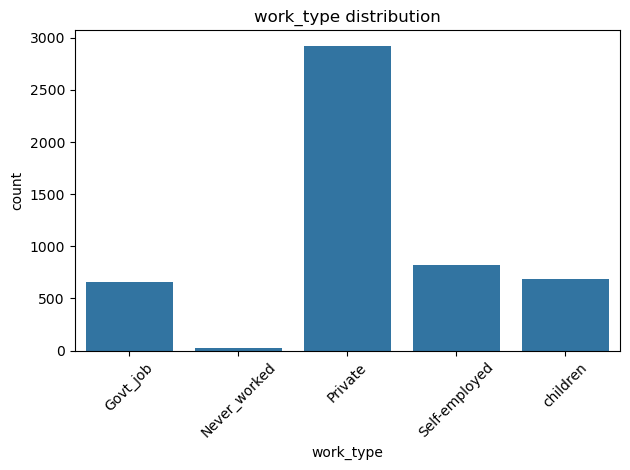

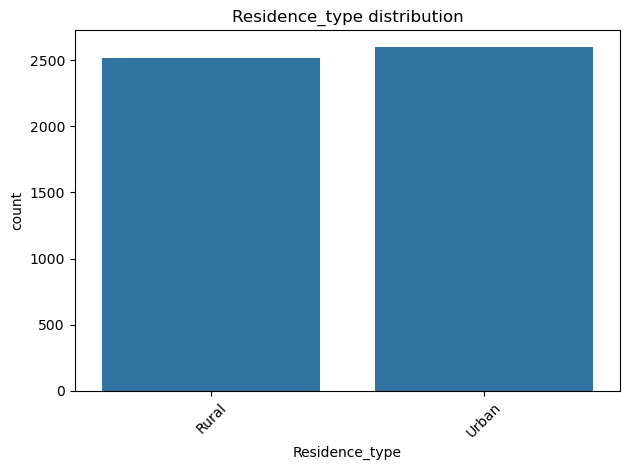

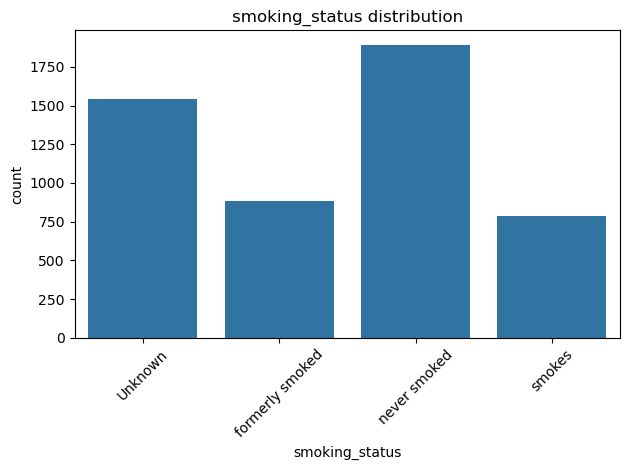

In [11]:
for col in categorical_cols:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} distribution')
    plt.xticks(rotation=45)
    plt.savefig(f'countplot_{col}.png')
    plt.tight_layout()
    plt.show()

Categorical countplots like gender, smoking_status, work_type show: most patients are female and have never smoked. Majority work in the private sector.

# Bivariate Analysis

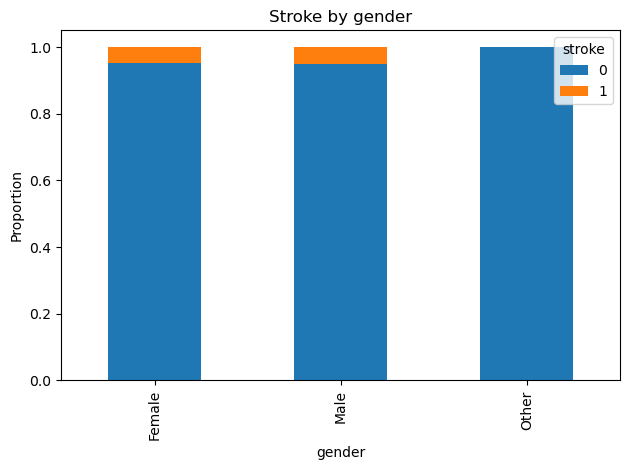

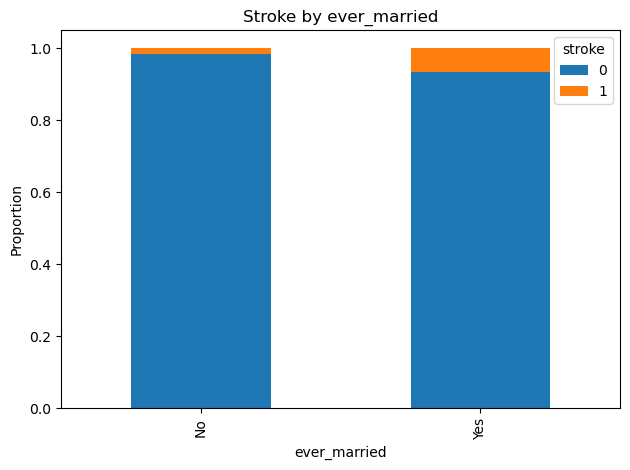

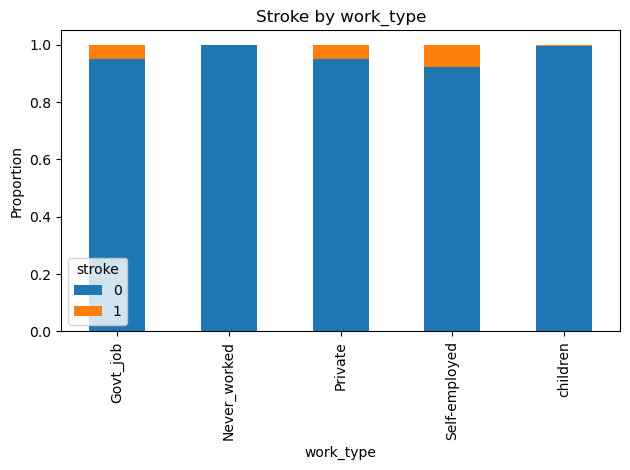

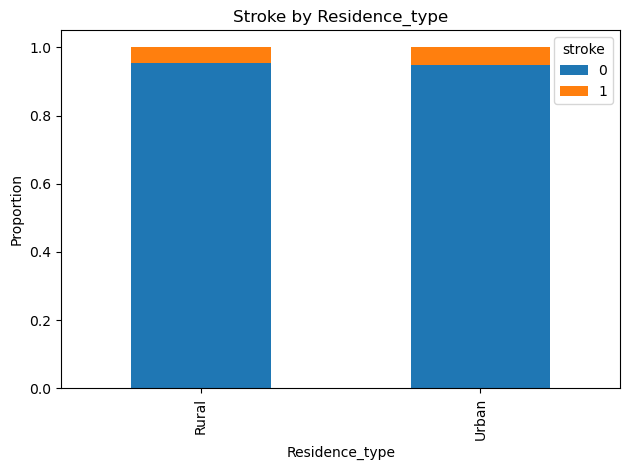

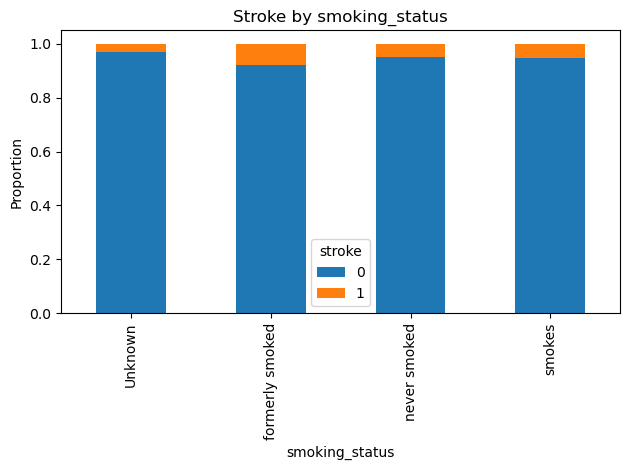

In [12]:
for col in categorical_cols:
    pd.crosstab(df[col], df['stroke'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'Stroke by {col}')
    plt.ylabel('Proportion')
    plt.savefig(f'stroke_by_{col}.png')
    plt.tight_layout()
    plt.show()

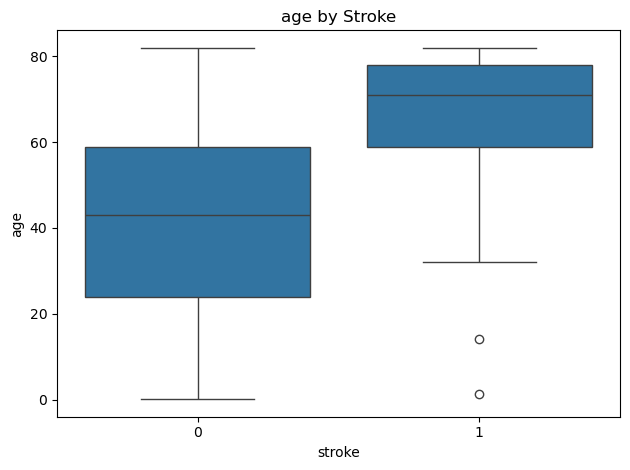

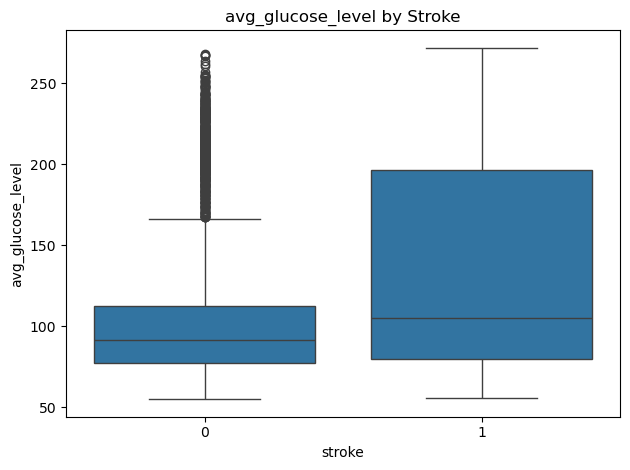

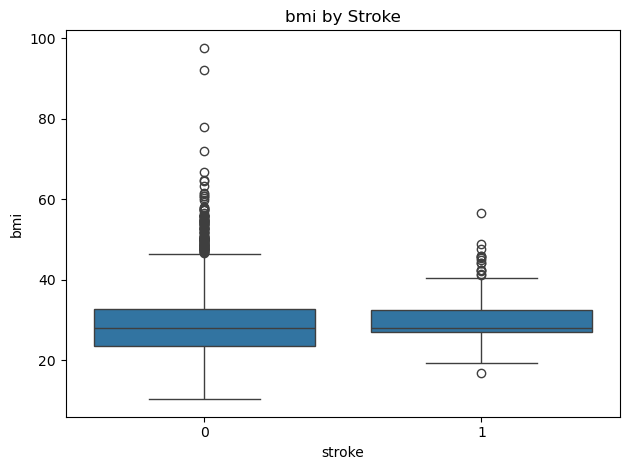

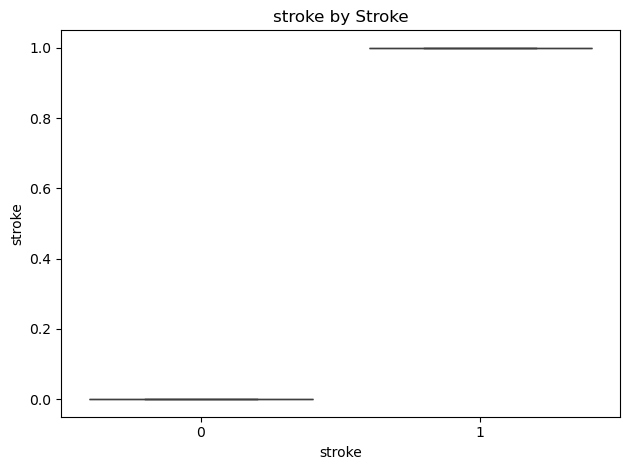

In [13]:
for col in num_cols:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} by Stroke')
    plt.savefig(f'boxplot_{col}_by_stroke.png') 
    plt.tight_layout()
    plt.show()

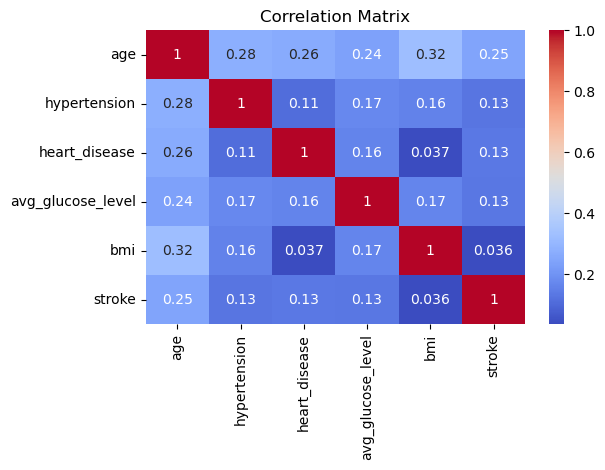

In [14]:
corr = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.tight_layout()  
plt.show()

### Summary of Bivariate Analysis
| Feature        | Strength of Association with Stroke  | Notes                                                     |
| -------------- | -----------------------------------  | ------------------------------------------------------    |
| Age            | Strong                               | Older people much more likely to have stroke              |
| Glucose Level  | Moderate                             | High glucose is a risk factor                             |
| Smoking Status | Moderate                             | "Formerly smoked" and "smokes" show elevated stroke risk  |
| Hypertension   | Moderate                             | Medically important though correlation is weak            |
| Heart Disease  | Moderate                             | Similar to hypertension                                   |
| Work Type      | Weak to Moderate                     | "Self-employed" and "Govt job" higher                     |
| BMI            | Weak                                 | Not strongly correlated alone                             |
| Gender         | Very Weak                            | No major difference                                       |
| Residence Type | None                                 | Urban and rural similar                                   |


# ANN model

In [15]:
# Split data into training (60%), validation (20%), and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) 

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
#scaler = StandardScaler()
X_train_scaled = StandardScaler().fit_transform(X_train_resampled)
X_val_scaled = StandardScaler().fit_transform(X_val)
X_test_scaled = StandardScaler().fit_transform(X_test)

# Train ANN model
ann_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
ann_model.fit(X_train_scaled, y_train_resampled)

# Evaluate ANN on validation and test sets
val_preds_ann = ann_model.predict(X_val_scaled)
test_preds_ann = ann_model.predict(X_test_scaled)

print("ANN Validation Accuracy:", accuracy_score(y_val, val_preds_ann))
print("ANN Test Accuracy:", accuracy_score(y_test, test_preds_ann))
print("ANN Validation Classification Report:\n", classification_report(y_val, val_preds_ann))
print("ANN Test Classification Report:\n", classification_report(y_test, test_preds_ann))


ANN Validation Accuracy: 0.6311154598825832
ANN Test Accuracy: 0.6066536203522505
ANN Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.63      0.76       972
           1       0.09      0.68      0.15        50

    accuracy                           0.63      1022
   macro avg       0.53      0.65      0.46      1022
weighted avg       0.93      0.63      0.73      1022

ANN Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.60      0.74       972
           1       0.08      0.72      0.15        50

    accuracy                           0.61      1022
   macro avg       0.53      0.66      0.45      1022
weighted avg       0.93      0.61      0.71      1022



# Linear Regression model

In [16]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_resampled)

# Evaluate Logistic Regression
val_preds_lr = lr_model.predict(X_val_scaled)
test_preds_lr = lr_model.predict(X_test_scaled)

print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, val_preds_lr))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, test_preds_lr))
print("Logistic Regression Validation Classification Report:\n", classification_report(y_val, val_preds_lr, zero_division=0))  # set undefined precision to zero
print("Logistic Regression Test Classification Report:\n", classification_report(y_test, test_preds_lr, zero_division=0))  # set undefined precision to zero


Logistic Regression Validation Accuracy: 0.5420743639921722
Logistic Regression Test Accuracy: 0.5450097847358122
Logistic Regression Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.53      0.69       972
           1       0.08      0.80      0.15        50

    accuracy                           0.54      1022
   macro avg       0.53      0.66      0.42      1022
weighted avg       0.94      0.54      0.66      1022

Logistic Regression Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69       972
           1       0.09      0.86      0.16        50

    accuracy                           0.55      1022
   macro avg       0.54      0.69      0.42      1022
weighted avg       0.94      0.55      0.66      1022



# Support Vector Machine (SVM) Model

In [17]:
# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Using linear kernel for SVM
svm_model.fit(X_train_scaled, y_train_resampled)

# Evaluate SVM Regression
val_preds_svm = svm_model.predict(X_val_scaled)
test_preds_svm = svm_model.predict(X_test_scaled)

print("SVM Validation Accuracy:", accuracy_score(y_val, val_preds_svm))
print("SVM Test Accuracy:", accuracy_score(y_test, test_preds_svm))
print("SVM Validation Classification Report:\n", classification_report(y_val, val_preds_svm, zero_division=0)) # set undefined precision to zero    
print("SVM Test Classification Report:\n", classification_report(y_test, test_preds_svm, zero_division=0)) # set undefined precision to zero

SVM Validation Accuracy: 0.5489236790606654
SVM Test Accuracy: 0.5499021526418787
SVM Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.54      0.69       972
           1       0.08      0.80      0.15        50

    accuracy                           0.55      1022
   macro avg       0.53      0.67      0.42      1022
weighted avg       0.94      0.55      0.67      1022

SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69       972
           1       0.09      0.88      0.16        50

    accuracy                           0.55      1022
   macro avg       0.54      0.71      0.43      1022
weighted avg       0.94      0.55      0.67      1022

